<a href="https://colab.research.google.com/github/deepsharma26/SIRT1_ML_NPASS/blob/main/Part8_Applicability_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data...
Loaded: MACCS_X_train_set.csv (n_train=670), MACCS_with_SMILES_merged_96235_top20_updated.csv (n_unknown=96235)
Found 20 common MACCSFP columns.
X_train shape: (670, 20) X_unknown shape: (96235, 20)

Computing pairwise training similarities (exclude self) — this may take time...
Done in 0.0s. Training size: 670
Sim threshold chosen from training P5: 0.7778
Training max-sim stats: min=0.0000, 5%=0.7778, 25%=0.9375, median=1.0000, mean=0.9576, max=1.0000

Computing Unknown->Training similarities in chunks (CHUNK_SIZE=2000)...
 processed 2000/96235 unknowns...
 processed 12000/96235 unknowns...
 processed 22000/96235 unknowns...
 processed 32000/96235 unknowns...
 processed 42000/96235 unknowns...
 processed 52000/96235 unknowns...
 processed 62000/96235 unknowns...
 processed 72000/96235 unknowns...
 processed 82000/96235 unknowns...
 processed 92000/96235 unknowns...
Done in 2.5s

Saved AD results to: MACCS_with_SMILES_AD_Checked.csv
IN: 30846 ; OUT: 65389 ; TOTAL: 96235

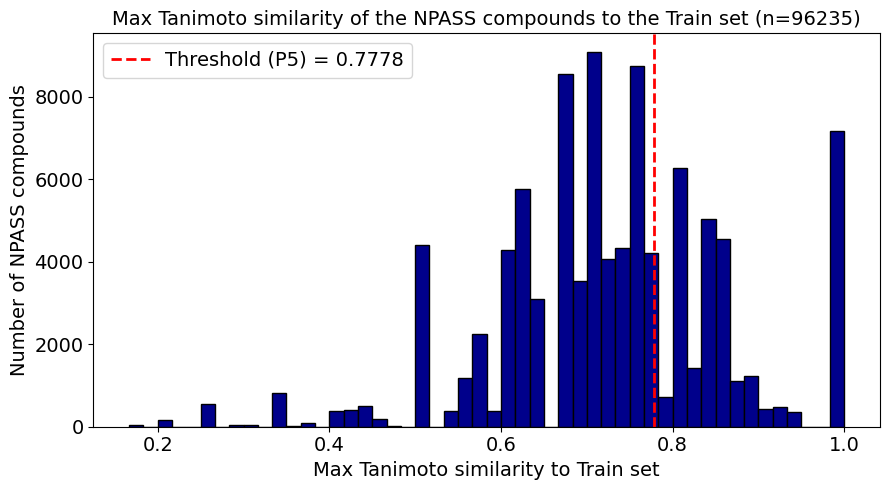

Histogram saved to: AD_MaxSim_Histogram.png

Core training count (train_max_sim >= threshold): 639 (of 670)
PCA will run on 3670 samples (670 train + 3000 unknown).
PCA box computed from core training (percentiles 2.5/97.5).


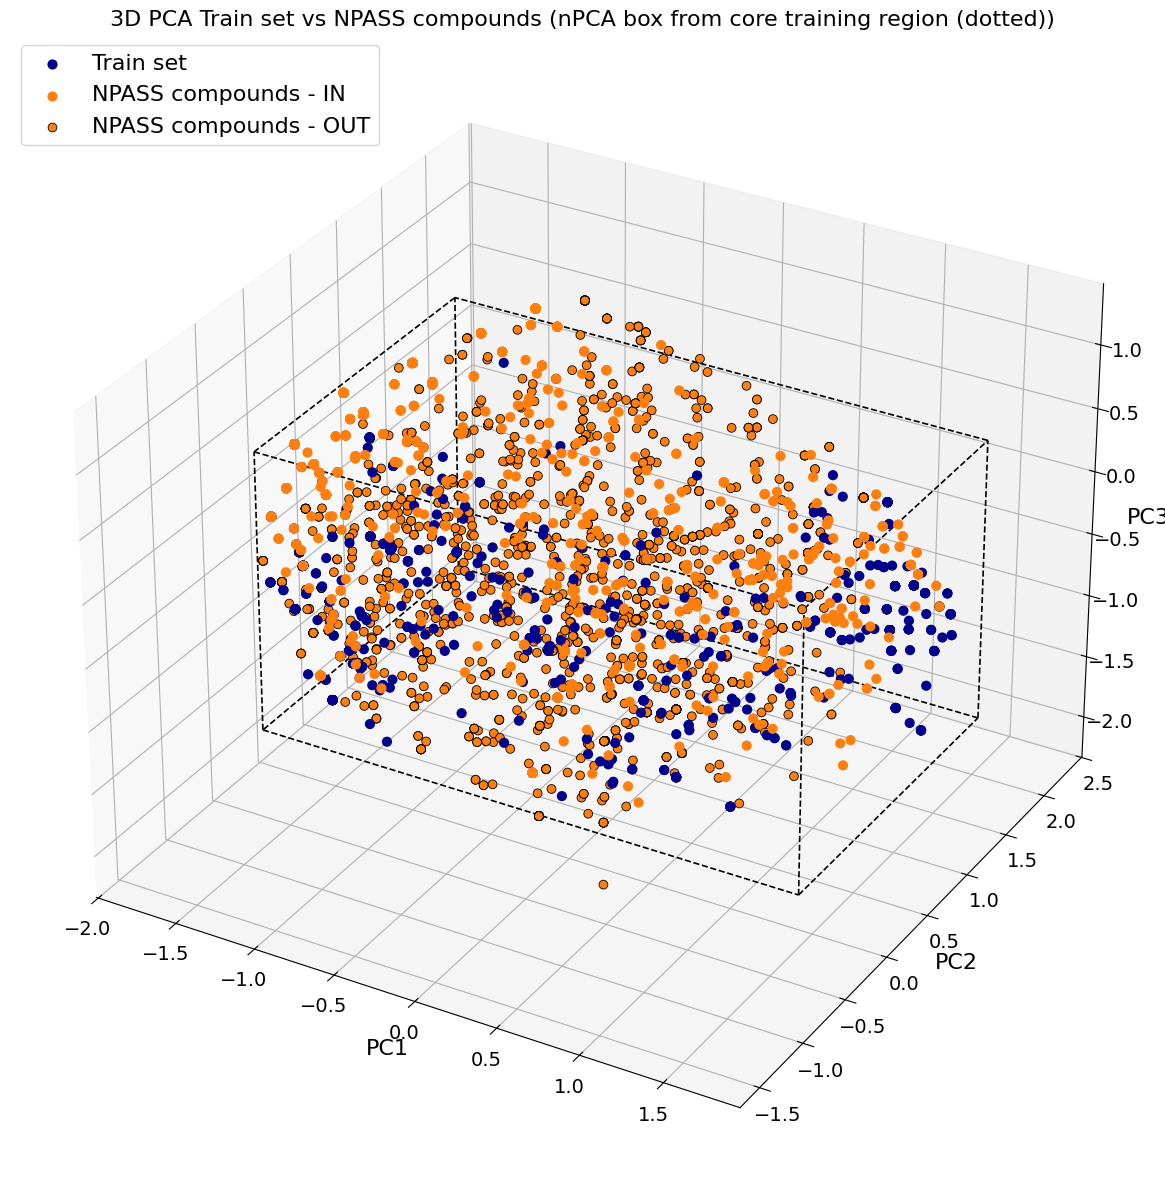

Saved 3D PCA plot to: PCA_AD_3D_box.png

First 10 OUT examples with nearest training neighbor index and similarity:
    Max_Tanimoto_to_Training  Best_Train_idx
0                   0.666667             317
1                   0.750000              54
4                   0.625000              61
5                   0.636364             620
6                   0.600000               0
7                   0.750000              61
8                   0.250000              11
9                   0.500000             378
10                  0.615385             567
13                  0.750000              61

Final AD-checked CSV saved (with Compound_ID): MACCS_with_SMILES_AD_Checked.csv

Done.


In [ ]:
!pip install --quiet scikit-learn pandas numpy matplotlib

import os
import numpy as np
import pandas as pd
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------------- User parameters (edit if needed) ----------------
TRAIN_FILE = "MACCS_X_train_set.csv"
UNKNOWN_FILE = "MACCS_with_SMILES_merged_96235_top20_updated.csv"

OUTPUT_FILE = "MACCS_with_SMILES_AD_Checked.csv"
OUT_IN_CSV = "Unknowns_IN_AD.csv"
OUT_OUT_CSV = "Unknowns_OUT_AD.csv"
HIST_PLOT = "AD_MaxSim_Histogram.png"
PCA_3D_PLOT = "PCA_AD_3D_box.png"

# AD thresholding:
PERCENTILE = 5               # percentile of training max-similarities used for threshold
FIXED_SIM_THRESHOLD = None   # set to float (0..1) to override percentile-based threshold (or keep None)

# Similarity chunking (for large unknown sets)
CHUNK_SIZE = 2000

# PCA plotting - sampling sizes for responsiveness
PCA_SAMPLE_TRAIN = 3000
PCA_SAMPLE_UNKNOWN = 3000
PCA_RANDOM_STATE = 42

# PCA box definition method for training core region: 'percentile' or 'std'
PCA_BOX_METHOD = 'percentile'
PCA_BOX_PARAM = 2.5
# -------------------------------------------------------------------

# -------------------- Basic checks & load ------------------------
for f in (TRAIN_FILE, UNKNOWN_FILE):
    if not os.path.exists(f):
        raise SystemExit(f"ERROR: Required file not found: {f}")

print("Loading data...")
df_train = pd.read_csv(TRAIN_FILE)
df_unknown = pd.read_csv(UNKNOWN_FILE)
print(f"Loaded: {TRAIN_FILE} (n_train={len(df_train)}), {UNKNOWN_FILE} (n_unknown={len(df_unknown)})")

# -------------------- Detect MACCSFP columns (use intersection) -----------
train_maccs = [c for c in df_train.columns if c.strip().startswith('MACCSFP')]
unknown_maccs = [c for c in df_unknown.columns if c.strip().startswith('MACCSFP')]
common_maccs_cols = sorted(list(set(train_maccs) & set(unknown_maccs)))

if not common_maccs_cols:
    raise SystemExit("No common MACCSFP columns found between train & unknown. Please fix column names.")

print(f"Found {len(common_maccs_cols)} common MACCSFP columns.")
if len(common_maccs_cols) < 20:
    print(f"⚠️ Warning: only {len(common_maccs_cols)} common MACCSFP features found (expected 20). Proceeding with intersection.")

# Build X matrices from intersection; missing values -> 0
X_train_df = df_train[common_maccs_cols].fillna(0).astype(int)
X_unknown_df = df_unknown[common_maccs_cols].fillna(0).astype(int)

X_train = X_train_df.values
X_unknown = X_unknown_df.values

print("X_train shape:", X_train.shape, "X_unknown shape:", X_unknown.shape)

# -------------------- Tanimoto similarity function ----------------
def tanimoto_similarity_matrix(A, B):
    A = np.asarray(A, dtype=np.int32)
    B = np.asarray(B, dtype=np.int32)
    sumA = A.sum(axis=1).reshape(-1, 1).astype(np.int32)
    sumB = B.sum(axis=1).reshape(1, -1).astype(np.int32)
    inter = A.dot(B.T).astype(np.int32)
    denom = (sumA + sumB - inter).astype(np.float64)
    with np.errstate(divide='ignore', invalid='ignore'):
        S = np.where(denom > 0, inter / denom, 1.0)
    return S

# -------------------- 1) Training pairwise similarities ----------------
print("\nComputing pairwise training similarities (exclude self) — this may take time...")
t0 = time()
S_tt = tanimoto_similarity_matrix(X_train, X_train)
np.fill_diagonal(S_tt, -np.inf)
train_max_sim = S_tt.max(axis=1)
print(f"Done in {time()-t0:.1f}s. Training size: {len(train_max_sim)}")

# -------------------- 2) Choose similarity threshold -------------------
if FIXED_SIM_THRESHOLD is None:
    sim_threshold = float(np.percentile(train_max_sim, PERCENTILE))
    print(f"Sim threshold chosen from training P{PERCENTILE}: {sim_threshold:.4f}")
else:
    sim_threshold = float(FIXED_SIM_THRESHOLD)
    print(f"Sim threshold fixed to: {sim_threshold:.4f}")

print("Training max-sim stats: min={:.4f}, 5%={:.4f}, 25%={:.4f}, median={:.4f}, mean={:.4f}, max={:.4f}".format(
    train_max_sim.min(), np.percentile(train_max_sim,5), np.percentile(train_max_sim,25),
    np.median(train_max_sim), train_max_sim.mean(), train_max_sim.max()
))

# -------------------- 3) Unknown -> training (in chunks) ----------------
n_unknown = X_unknown.shape[0]
unknown_max_sim = np.empty(n_unknown, dtype=np.float64)
unknown_best_train_idx = np.empty(n_unknown, dtype=np.int64)

print(f"\nComputing Unknown->Training similarities in chunks (CHUNK_SIZE={CHUNK_SIZE})...")
t0 = time()
for start in range(0, n_unknown, CHUNK_SIZE):
    end = min(n_unknown, start + CHUNK_SIZE)
    S_chunk = tanimoto_similarity_matrix(X_unknown[start:end], X_train)
    unknown_max_sim[start:end] = S_chunk.max(axis=1)
    unknown_best_train_idx[start:end] = S_chunk.argmax(axis=1)
    if ((start // CHUNK_SIZE) % 5) == 0:
        print(f" processed {end}/{n_unknown} unknowns...")
print(f"Done in {time()-t0:.1f}s")

# -------------------- 4) Assign AD status (NN Tanimoto method) -----
ad_status = np.where(unknown_max_sim >= sim_threshold, 'IN', 'OUT')
df_unknown['Max_Tanimoto_to_Training'] = unknown_max_sim
df_unknown['AD_Sim_Threshold'] = sim_threshold
df_unknown['AD_Status'] = ad_status
df_unknown['Best_Train_idx'] = unknown_best_train_idx

# -------------------- 5) Preserve original ID column (prefer np_id) --------------------
preferred = None
for col in ['np_id', 'Compound_ID', 'ID']:
    if col in df_unknown.columns:
        preferred = col
        break

if preferred is not None:
    # Ensure string dtype and fill only truly missing entries (do not overwrite existing IDs)
    df_unknown[preferred] = df_unknown[preferred].astype(str)

    # mask for genuinely missing/empty entries
    mask_missing = df_unknown[preferred].isnull() | (df_unknown[preferred].str.strip() == '') | (df_unknown[preferred] == 'nan')
    if mask_missing.any():
        # create minimal fillers only for missing entries
        start_index = 1
        width = max(6, len(str(len(df_unknown) + start_index - 1)))
        fillers = ['NPC' + str(i).zfill(width) for i in range(start_index, start_index + mask_missing.sum())]
        df_unknown.loc[mask_missing, preferred] = fillers

    # Move the chosen id column to the front (safe because preferred exists)
    cols = df_unknown.columns.tolist()
    cols = [preferred] + [c for c in cols if c != preferred]
    df_unknown = df_unknown[cols]

else:
    # No ID column found at all — create Compound_ID (only then)
    start_index = 1
    width = max(6, len(str(len(df_unknown) + start_index - 1)))
    df_unknown['Compound_ID'] = ['NPC' + str(i).zfill(width) for i in range(start_index, start_index + len(df_unknown))]
    cols = ['Compound_ID'] + [c for c in df_unknown.columns if c != 'Compound_ID']
    df_unknown = df_unknown[cols]

# -------------------- 6) Save AD results and IN/OUT lists ----------------
df_unknown.to_csv(OUTPUT_FILE, index=False)
df_unknown[df_unknown['AD_Status']=='IN'].to_csv(OUT_IN_CSV, index=False)
df_unknown[df_unknown['AD_Status']=='OUT'].to_csv(OUT_OUT_CSV, index=False)

num_in = (df_unknown['AD_Status']=='IN').sum()
num_out = (df_unknown['AD_Status']=='OUT').sum()
print(f"\nSaved AD results to: {OUTPUT_FILE}")
print(f"IN: {num_in} ; OUT: {num_out} ; TOTAL: {len(df_unknown)}")

# -------------------- 7) Histogram of Unknown (NPASS) max-similarities ----------------
plt.figure(figsize=(9,5))
plt.hist(unknown_max_sim, bins=50, color='darkblue', edgecolor='black', alpha=1.0)
plt.axvline(sim_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (P{PERCENTILE}) = {sim_threshold:.4f}')
plt.xlabel('Max Tanimoto similarity to Train set', fontsize=14)
plt.ylabel('Number of NPASS compounds', fontsize=14)
plt.title(f'Max Tanimoto similarity of the NPASS compounds to the Train set (n={len(df_unknown)})', fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(HIST_PLOT, dpi=300)
plt.show()
print(f"Histogram saved to: {HIST_PLOT}")

# -------------------- 8) PCA 3D plot and PCA box from same core Train region -------------
core_train_idx = np.where(train_max_sim >= sim_threshold)[0]
print(f"\nCore training count (train_max_sim >= threshold): {len(core_train_idx)} (of {len(train_max_sim)})")

# Sample points for plotting
rng = np.random.RandomState(PCA_RANDOM_STATE)
n_train = X_train.shape[0]
n_unknown = X_unknown.shape[0]

train_idx_plot = rng.choice(np.arange(n_train), size=min(PCA_SAMPLE_TRAIN, n_train), replace=False)
unknown_idx_plot = rng.choice(np.arange(n_unknown), size=min(PCA_SAMPLE_UNKNOWN, n_unknown), replace=False)

X_plot_train = X_train[train_idx_plot]
X_plot_unknown = X_unknown[unknown_idx_plot]
concat_X = np.vstack([X_plot_train, X_plot_unknown])
print(f"PCA will run on {len(concat_X)} samples ({len(X_plot_train)} train + {len(X_plot_unknown)} unknown).")

pca3 = PCA(n_components=3, random_state=PCA_RANDOM_STATE)
Z3 = pca3.fit_transform(concat_X)
Z_train_3 = Z3[:len(X_plot_train)]
Z_unknown_3 = Z3[len(X_plot_train):]

# Determine core training points within plotted sample
core_mask_in_plot = np.isin(train_idx_plot, core_train_idx)
Z_train_core = Z_train_3[core_mask_in_plot]
if Z_train_core.shape[0] == 0:
    print("Warning: No core training points are present in the plotted sample. Consider increasing PCA_SAMPLE_TRAIN.")
    Z_train_core = Z_train_3.copy()

# Compute PCA box bounds from Z_train_core
if PCA_BOX_METHOD == 'percentile':
    lowp = PCA_BOX_PARAM
    highp = 100.0 - PCA_BOX_PARAM
    mins = np.percentile(Z_train_core, lowp, axis=0)
    maxs = np.percentile(Z_train_core, highp, axis=0)
    desc = f"percentiles {lowp}/{highp}"
else:
    k = PCA_BOX_PARAM
    means = Z_train_core.mean(axis=0)
    stds = Z_train_core.std(axis=0)
    mins = means - k * stds
    maxs = means + k * stds
    desc = f"mean +/- {k}*std"

print(f"PCA box computed from core training ({desc}).")

# helper to draw 3D wireframe box
def draw_3d_box(ax, mins, maxs, color='k', linewidth=1.2, linestyle='--'):
    x0, x1 = mins[0], maxs[0]
    y0, y1 = mins[1], maxs[1]
    z0, z1 = mins[2], maxs[2]
    corners = np.array([[x0,y0,z0],[x1,y0,z0],[x1,y1,z0],[x0,y1,z0],
                        [x0,y0,z1],[x1,y0,z1],[x1,y1,z1],[x0,y1,z1]])
    edges = [(0,1),(1,2),(2,3),(3,0),
             (4,5),(5,6),(6,7),(7,4),
             (0,4),(1,5),(2,6),(3,7)]
    for i,j in edges:
        xs = [corners[i,0], corners[j,0]]
        ys = [corners[i,1], corners[j,1]]
        zs = [corners[i,2], corners[j,2]]
        ax.plot(xs, ys, zs, color=color, linewidth=linewidth, linestyle=linestyle)

# Colors
train_color = 'darkblue'   # blue
unknown_color = '#ff7f0e' # orange

# Prepare IN/OUT masks for plotted unknowns
unknown_plot_status = df_unknown['AD_Status'].values[unknown_idx_plot]
mask_in = unknown_plot_status == 'IN'
mask_out = unknown_plot_status == 'OUT'

# Create 3D scatter with proper legend entries
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# Plot training points (label once)
h_train = ax.scatter(Z_train_3[:,0], Z_train_3[:,1], Z_train_3[:,2],
           c=train_color, s=40, alpha=1.0, label='Train set')

# Plot unknown INs
if mask_in.sum() > 0:
    h_in = ax.scatter(Z_unknown_3[mask_in,0], Z_unknown_3[mask_in,1], Z_unknown_3[mask_in,2],
           c=unknown_color, s=40, alpha=1.0, label='NPASS compounds - IN')

# Plot unknown OUTs (bigger marker with black edge)
if mask_out.sum() > 0:
    h_out = ax.scatter(Z_unknown_3[mask_out,0], Z_unknown_3[mask_out,1], Z_unknown_3[mask_out,2],
           facecolors=unknown_color, edgecolors='k', s=40, alpha=1.0, linewidths=0.6, label='NPASS compounds - OUT')

# Draw PCA box (dotted wireframe) computed from core training region
draw_3d_box(ax, mins, maxs, color='k', linewidth=1.2, linestyle='--')

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='z', labelsize=14)

ax.set_xlabel('PC1', fontsize=16)
ax.set_ylabel('PC2', fontsize=16)
ax.set_zlabel('PC3', fontsize=16)
ax.set_title('3D PCA Train set vs NPASS compounds (nPCA box from core training region (dotted))', fontsize=16)

# Build legend manually to ensure proper labels
handles = []
labels = []
handles.append(h_train)
labels.append('Train set')
if mask_in.sum() > 0:
    handles.append(h_in)
    labels.append('NPASS compounds - IN')
if mask_out.sum() > 0:
    handles.append(h_out)
    labels.append('NPASS compounds - OUT')

ax.legend(handles=handles, labels=labels, loc='upper left', fontsize=16)

plt.tight_layout()
plt.savefig(PCA_3D_PLOT, dpi=300)
plt.show()
print(f"Saved 3D PCA plot to: {PCA_3D_PLOT}")

# -------------------- 9) Show a few OUT examples and their nearest training neighbor --------------------
print("\nFirst 10 OUT examples with nearest training neighbor index and similarity:")
outs = df_unknown[df_unknown['AD_Status']=='OUT'].head(10).copy()
cols_show = ['Compound_ID','Max_Tanimoto_to_Training','Best_Train_idx'] if 'Compound_ID' in df_unknown.columns else ['Max_Tanimoto_to_Training','Best_Train_idx']
print(outs[cols_show])

# Optionally map Best_Train_SMILES/ID if available in training dataframe
if 'SMILES' in df_train.columns:
    df_unknown['Best_Train_SMILES'] = df_train.iloc[df_unknown['Best_Train_idx']].get('SMILES').values
if 'ID' in df_train.columns:
    df_unknown['Best_Train_ID'] = df_train.iloc[df_unknown['Best_Train_idx']].get('ID').values

# Save final updated CSV again
df_unknown.to_csv(OUTPUT_FILE, index=False)
print(f"\nFinal AD-checked CSV saved (with Compound_ID): {OUTPUT_FILE}")

print("\nDone.")


Saving the files in zip formate

In [ ]:
!zip AD_SIRT1_ML * .csv * .png

	zip warning: name not matched: .csv
	zip warning: name not matched: .png
  adding: AD_MaxSim_Histogram.png (deflated 19%)
  adding: MACCS_with_SMILES_AD_Checked.csv (deflated 83%)
  adding: MACCS_with_SMILES_merged_96235_top20_updated.csv (deflated 78%)
  adding: MACCS_X_train_set.csv (deflated 91%)
  adding: PCA_AD_3D_box.png (deflated 7%)
  adding: sample_data/ (stored 0%)
  adding: Unknowns_IN_AD.csv (deflated 84%)
  adding: Unknowns_OUT_AD.csv (deflated 84%)
